In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import acquire

In [3]:
colnames = ['date', 'time', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv('anonymized-curriculum-access-07-2021.txt',  
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 1, 2, 3, 4, 5])

In [4]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018810 entries, 0 to 1018809
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   date       1018810 non-null  object 
 1   time       1018810 non-null  object 
 2   endpoint   1018809 non-null  object 
 3   user_id    1018810 non-null  int64  
 4   cohort_id  965313 non-null   float64
 5   source_ip  1018810 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 46.6+ MB


### Prepare

In [6]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [7]:
df.time = pd.to_datetime(df.time)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1018810 entries, 2018-01-26 to 2021-07-15
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   date       1018810 non-null  datetime64[ns]
 1   time       1018810 non-null  datetime64[ns]
 2   endpoint   1018809 non-null  object        
 3   user_id    1018810 non-null  int64         
 4   cohort_id  965313 non-null   float64       
 5   source_ip  1018810 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 54.4+ MB


In [9]:
# resample daily counts for number of page views

pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

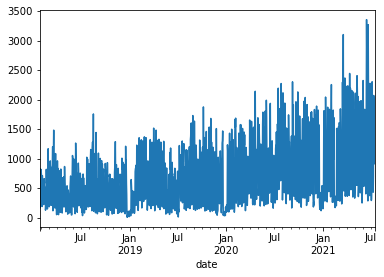

In [10]:
#plot pages
pages.plot()

Not splitting b/c not modeling. Using stats to identify cases

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value.

<AxesSubplot:xlabel='date'>

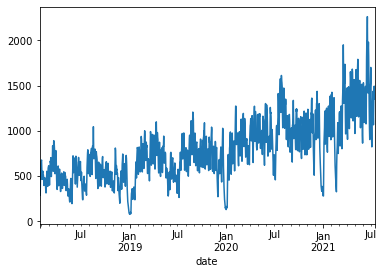

In [11]:
# 7 day EMA
ema_7d = pages.ewm(span = 7).mean()
ema_7d.plot()

<AxesSubplot:xlabel='date'>

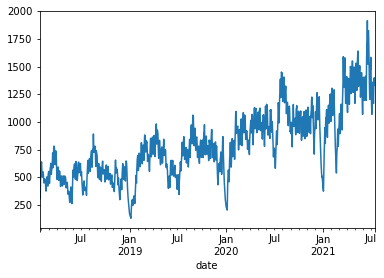

In [12]:
# 14 days EMA
ema_14d = pages.ewm(span = 14).mean()
ema_14d.plot()

In [13]:
# 30 days EMA
ema_30d = pages.ewm(span = 30).mean()

In [14]:
# 90 days EMA
ema_90d = pages.ewm(span = 90).mean()

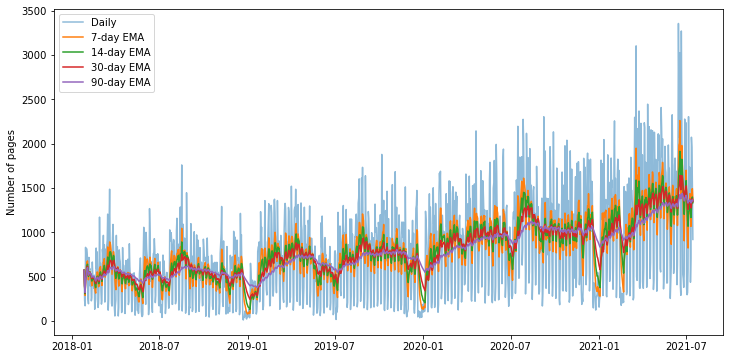

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Note: the longer the period the less noisy.  The EMA reduces the impact of volatility on the Daily observation

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$



In [16]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span = 30).mean()
midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [17]:
# compute exponential moving stdev
std = pages.ewm(span = 30).std()
std.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [18]:
# compute upper and lower bands
ub = midband + std * 2
lb = midband - std * 2

ub.head()

date
2018-01-26            NaN
2018-01-27     878.961038
2018-01-28     742.895854
2018-01-29    1089.938060
2018-01-30    1070.328518
Freq: D, Name: endpoint, dtype: float64

In [19]:
# concat pages, midband, lb and ub to create a new df 'my_df'

my_df = pd.concat([pages, midband, ub, lb], axis =1)

my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038
2018-01-28,170,315.139578,742.895854,-112.616698
2018-01-29,830,457.002386,1089.938060,-175.933288
2018-01-30,652,501.369064,1070.328518,-67.590389


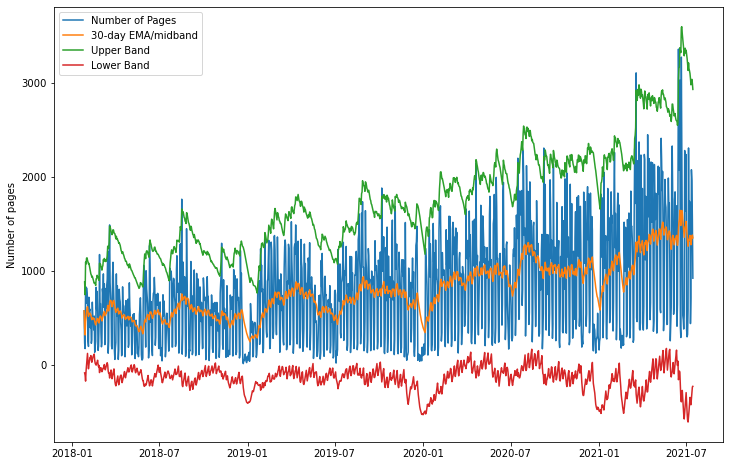

In [20]:
# Plot the bands
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Note: 

* The lower Bollinger Band is not relevant considering we can't have negative observations. 
    
* The Daily observations do not appear to cross the upper band @ 3 standard devations from the chart. A small number of observations appear to come close, worth investigating

    * after adjusting the bands to 2 standard deviations, we do start to see the upper band start acting as a resistance threshold with more observations testing the range but still a relatively small amount

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

In [21]:
# compute % b for each point
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/ (my_df['ub'] - my_df['lb'])
my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374


In [22]:
# After finding no observations crossed the upper Bollinger Band at 3 standard deviations, let's check at 2 standard deviations
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845


In [23]:
my_df[my_df.pct_b > 1].count()

pages      13
midband    13
ub         13
lb         13
pct_b      13
dtype: int64

Note: After adjusting to 2 standard deviations we see the upper BB acting as an upper boundary.  We have 13 observations that cross the threshold but 0 that remain above the BB for 2 consecutive days.  

### Put it all together

1. acquire
2. prep with user
3. compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. search for anomalies

In [24]:
def acquire(file_name, column_names):
    ''' read in txt file into df and assign column names'''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 1, 2, 3, 4, 5])

def prep(df, user):
    '''prep df by converting date from object into datetime format and setting as index. Rename and resample endpoint column to daily counts given user_id'''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''computing [midband, std, upperband, lowerband], filtering df by defined user_id and concating all into one df'''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev * weight
    lb = midband - stdev * weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    #     plt_bands(my_df, user)
    return my_df[my_df.pct_b > 1]

1) acquire

In [25]:
df = acquire('anonymized-curriculum-access-07-2021.txt', ['date', 'time', 'endpoint', 'user_id', 'cohort_id', 'source_ip'])

In [26]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018810 entries, 0 to 1018809
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   date       1018810 non-null  object 
 1   time       1018810 non-null  object 
 2   endpoint   1018809 non-null  object 
 3   user_id    1018810 non-null  int64  
 4   cohort_id  965313 non-null   float64
 5   source_ip  1018810 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 46.6+ MB


2) prep with user

In [28]:
df.user_id.max()

1082

In [29]:
prep(df, 40)

date
2018-01-26     1
2018-01-27     0
2018-01-28     0
2018-01-29    14
2018-01-30     1
              ..
2020-03-13     0
2020-03-14     0
2020-03-15     0
2020-03-16     0
2020-03-17     3
Freq: D, Name: endpoint, Length: 782, dtype: int64

3. compute features
    
* compute midband
* compute standard deviation
* compute upper & lower band
* create df with metrics
* compute %b
* add user_id to dataframe

In [63]:
my_df = compute_pct_b(pages, 30, 3, 40)
   

In [64]:
my_df.head()

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN,40
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077,40
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899,40
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438,40
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249,40


4) Plot

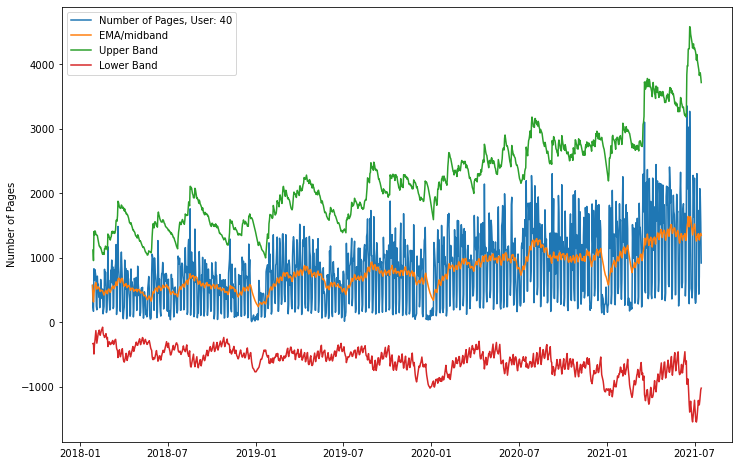

In [32]:
 plt_bands(my_df, 40)

5. search for anomalies

In [33]:
# compute %b for each point
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/ (my_df['ub'] - my_df['lb'])
my_df.head()

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN,40
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077,40
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899,40
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438,40
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249,40


In [65]:
# find anomalies for user_id 40 given pct_b > 1 threshold
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,


Note for user 40: 
* No anomalies given percent b > 1

In [78]:
# Now will loop through all users for anomalies at 3 standard deviations
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [79]:
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-06-02,72,10.456225,71.377304,-50.464854,1.005111,925
2021-06-29,32,3.881578,31.571606,-23.808449,1.007736,929
2021-06-11,44,5.582783,43.858655,-32.693089,1.001846,961


In [89]:
# Sort by pages count
anomalies.pages.value_counts(ascending=False)

4      87
3      85
5      62
6      61
8      60
       ..
89      1
93      1
56      1
96      1
343     1
Name: pages, Length: 105, dtype: int64

In [103]:
# look observation with 343 pages and count of 1
anomalies[anomalies.pages == 343]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-06-21,343,22.370564,322.155049,-277.413921,1.034767,804


In [104]:
# reference the user_id above and compare all associated anomalous observations
anomalies[anomalies.user_id == 804]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2021-01-20,74,8.832557,73.838286,-56.173171,1.001244,804
2021-06-21,343,22.370564,322.155049,-277.413921,1.034767,804


In [105]:
# continue to dig deeper and reference all observations for user 804
df[df.user_id == 804]

,date,time,endpoint,user_id,cohort_id,source_ip
719859,2020-11-03,10:15:51,javascript-i,804,132.0,69.91.64.132
720925,2020-11-04,09:00:55,javascript-i,804,132.0,69.91.64.132
721318,2020-11-04,11:40:16,javascript-i/javascript-with-html,804,132.0,69.91.64.132
721321,2020-11-04,11:40:28,javascript-i,804,132.0,69.91.64.132
721324,2020-11-04,11:40:33,javascript-i/introduction/primitive-types,804,132.0,69.91.64.132
...,...,...,...,...,...,...
987643,2021-06-21,14:17:37,appendix/further-reading/pagination,804,132.0,66.69.1.31
987644,2021-06-21,14:17:37,appendix/further-reading/authorization,804,132.0,66.69.1.31
987645,2021-06-21,14:17:58,appendix/further-reading/security-use-cases,804,132.0,66.69.1.31
987646,2021-06-21,14:17:58,appendix/further-reading/spring,804,132.0,66.69.1.31


***
Takaway:

* Looks as though user 804 is scraping the website given:
    * the number of pages visted each day and the multiple events
    * the time elapsed during the span of those page visits looks to be under 1 second which is too fast to be manual
***

#### Import Cohort Table from SQL

In [39]:
from env import username, host, password 
def get_connection(db, username=username, host=host, password=password):
    '''
    This function uses my info from my env file to create a connection url to access the Codeup SQL db
    '''
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

In [40]:
def cohorts_data():
    '''
    This function reads the cohorts table from the Codeup curriculum_logs db into a df
    '''
    
    # Create SQL query
    sql_query = '''
                SELECT *                    
                FROM cohorts
                '''

    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('curriculum_logs'))

    return df

# Cache'ing Log Data
def cache_cohorts_data(cached=False):
    '''
    This function reads in cohorts table data from Codeup curriculum_logs database and writes data to
    a csv file if cached == False or if cached == True reads in cohorts df from
    a csv file, returns df.
    '''
    if cached == False or os.path.isfile('cohorts_df.csv') == False:

        # Read fresh data from db into a DataFrame
        df = cohorts_data()

        # Cache data
        df.to_csv('cohorts_data.csv')

    else:

        # If csv file exists or cached == True, read in data from csv file.
        df = pd.read_csv('cohorts_data.csv', index_col=0)

In [41]:
cohorts_df = cohorts_data()

In [42]:
cohorts_df.head()

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1


In [43]:
cohorts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53 non-null     int64 
 1   name        53 non-null     object
 2   slack       53 non-null     object
 3   start_date  53 non-null     object
 4   end_date    53 non-null     object
 5   created_at  53 non-null     object
 6   updated_at  53 non-null     object
 7   deleted_at  0 non-null      object
 8   program_id  53 non-null     int64 
dtypes: int64(2), object(7)
memory usage: 3.9+ KB


In [44]:
dt=['end_date', 'start_date', 'created_at', 'updated_at']
cohorts_df[dt] = cohorts_df[dt].apply(pd.to_datetime)

In [45]:
cohorts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          53 non-null     int64         
 1   name        53 non-null     object        
 2   slack       53 non-null     object        
 3   start_date  53 non-null     datetime64[ns]
 4   end_date    53 non-null     datetime64[ns]
 5   created_at  53 non-null     datetime64[ns]
 6   updated_at  53 non-null     datetime64[ns]
 7   deleted_at  0 non-null      object        
 8   program_id  53 non-null     int64         
dtypes: datetime64[ns](4), int64(2), object(3)
memory usage: 3.9+ KB


In [46]:
cohorts_df = cohorts_df.drop(columns=('deleted_at'))

In [47]:
cohorts_df.head()

,id,name,slack,start_date,end_date,created_at,updated_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,1


In [48]:
cohorts_df.id.sort_values()

0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10     11
11     12
12     13
13     14
14     15
15     16
16     17
17     18
18     19
19     20
20     21
21     22
22     23
23     24
24     25
25     26
26     27
27     28
28     29
29     30
30     31
31     32
32     33
33     34
34     51
35     52
36     53
37     55
38     56
39     57
40     58
41     59
42     60
43     61
44     62
45    132
46    133
47    134
48    135
49    136
50    137
51    138
52    139
Name: id, dtype: int64

In [49]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [50]:
merged_df = df.merge(cohorts_df, left_on='cohort_id', right_on='id')

In [51]:
merged_df.head(1)

,date,time,endpoint,user_id,cohort_id,source_ip,id,name,slack,start_date,end_date,created_at,updated_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1


In [52]:
merged_df.to_csv('log.csv', index=False)

In [53]:
merged_df.isnull().sum()

date          0
time          0
endpoint      1
user_id       0
cohort_id     0
source_ip     0
id            0
name          0
slack         0
start_date    0
end_date      0
created_at    0
updated_at    0
program_id    0
dtype: int64

In [54]:
merged_df.shape

(954313, 14)